# Import Package

In [4]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from  matplotlib import pyplot as plt
import splitfolders
%matplotlib inline

# Split Data

In [5]:
BASE_DIR = 'Dataset'

In [6]:
splitfolders.ratio(BASE_DIR, output='data-split-80-20', seed=42, ratio=(.8, .2,))

Copying files: 8982 files [00:48, 184.32 files/s]


# Generate Data

In [7]:
IMAGE_SHAPE = (300, 300)
TRAINING_DATA_DIR = 'data-split-80-20/train'
VALID_DATA_DIR = 'data-split-80-20/val'

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 7185 images belonging to 3 classes.
Found 1797 images belonging to 3 classes.


# Build Model

In [9]:
def build_model(num_classes):
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model
model = build_model(num_classes=3)

# Compile Model

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 39200)             0

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    min_delta=0.001, 
    mode='max'
    )

In [12]:
EPOCHS = 5
BATCH_SIZE = 32
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE,
                    verbose=1,
                    callbacks=[early_stopping]
                    )

Epoch 1/5


c:\Users\ASUS\anaconda3\envs\data-science\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


224/224 [==============================] - 234s 1s/step - loss: 0.6014 - accuracy: 0.7437 - val_loss: 0.2607 - val_accuracy: 0.9247
Epoch 2/5
224/224 [==============================] - 262s 1s/step - loss: 0.2311 - accuracy: 0.9231 - val_loss: 0.1790 - val_accuracy: 0.9381
Epoch 3/5
224/224 [==============================] - 236s 1s/step - loss: 0.1753 - accuracy: 0.9414 - val_loss: 0.1415 - val_accuracy: 0.9492
Epoch 4/5
224/224 [==============================] - 226s 1s/step - loss: 0.1390 - accuracy: 0.9525 - val_loss: 0.1554 - val_accuracy: 0.9475
Epoch 5/5
224/224 [==============================] - 196s 877ms/step - loss: 0.1199 - accuracy: 0.9607 - val_loss: 0.1242 - val_accuracy: 0.9565


# Plot History

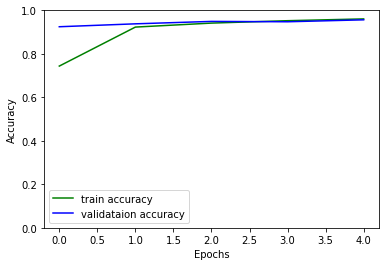

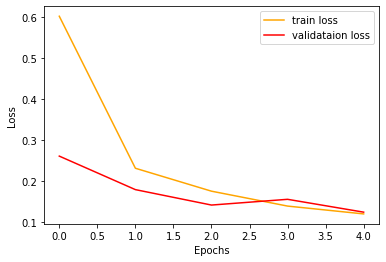

In [13]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim([0,1])
    plt.savefig('accuracy.png')
    
    # loss plots
    plt.figure(figsize=(6, 4))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

# Save Model

In [14]:
import datetime
model.save(f'{str(datetime.datetime.now())[:10]}-{round(train_acc[len(train_acc)-1]* 100, 2)}_acc.h5')
